In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [16]:
from rectification.augmentation import *
from infererence.preprocessing import *
from infererence.object_detection import Model
import random
import cv2
import matplotlib.pyplot as plt

In [3]:
# Load all imanges from logistics.zip
zip_file_path = os.path.join('..', 'logistics.zip')
images, image_names = load_images_from_zip(zip_file_path)

In [4]:
# Select 10 random images
selected_images = random.sample(images, 10)

In [14]:
augmented_images = []
for img in selected_images:
    flipped = horizontal_flip(img)
    blurred = gaussian_blur(img)
    resized = resize(img, new_size=(120, 120))
    brightened = adjust_brightness(image, value=70)
    augmented_images.append([img, flipped, blurred, resized, brightened])

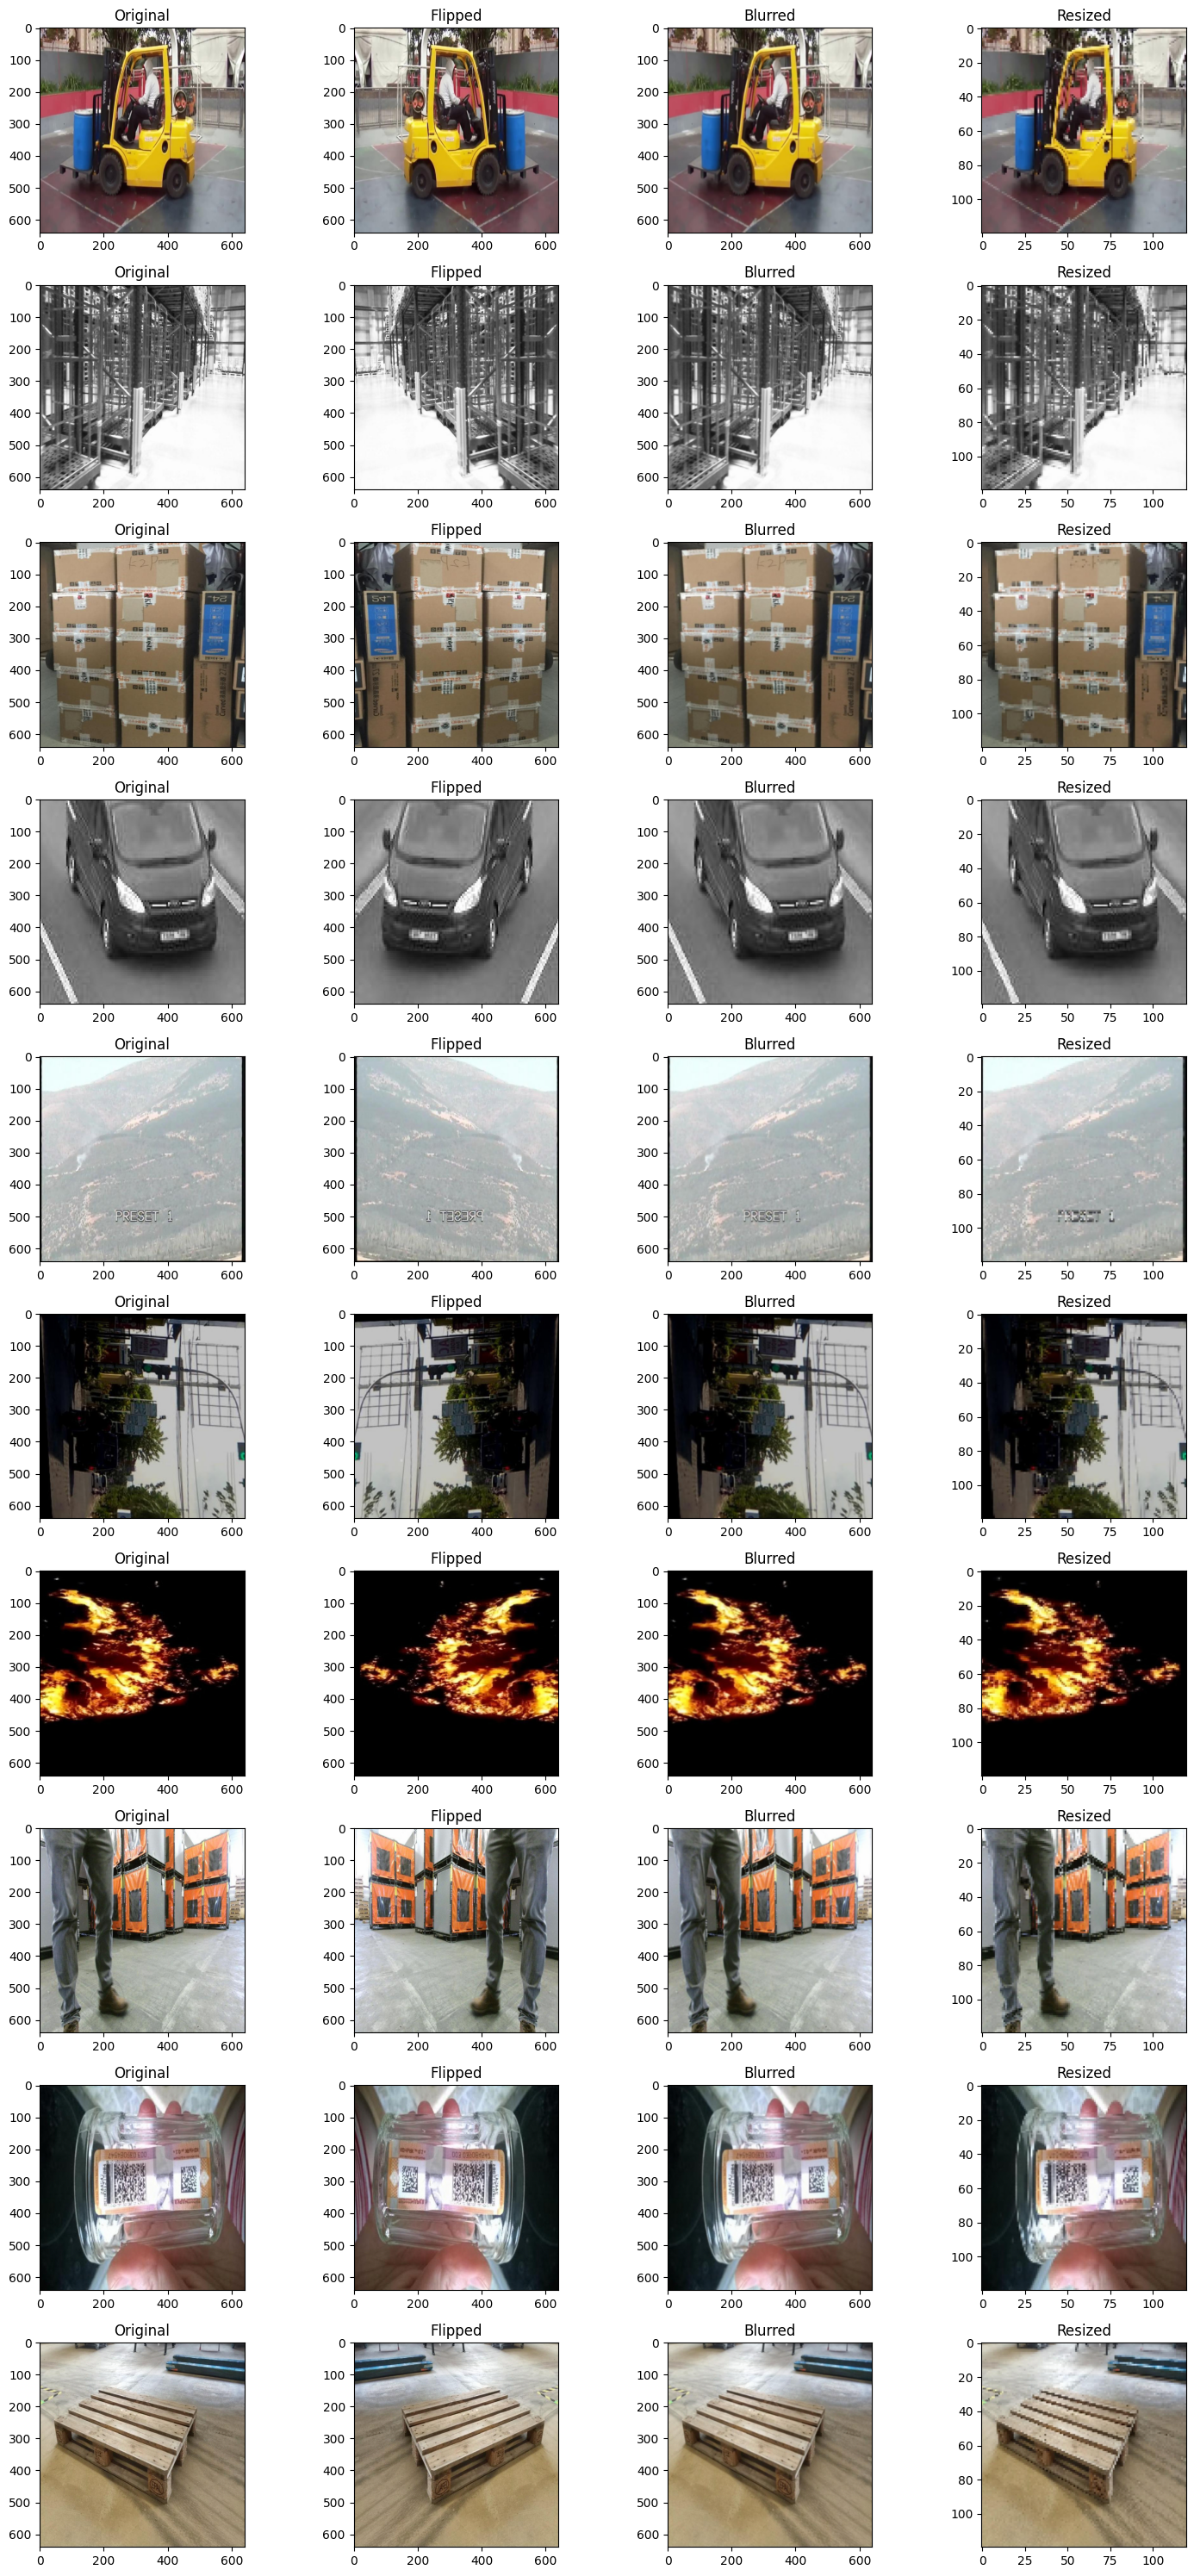

In [15]:
# Visualize original and augmented images
fig, axes = plt.subplots(10, 4, figsize=(15, 30))

for i, img_set in enumerate(augmented_images):
    original, flipped, blurred, resized = img_set
    axes[i, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(cv2.cvtColor(flipped, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("Flipped")
    axes[i, 2].imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title("Blurred")
    axes[i, 3].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    axes[i, 3].set_title("Resized")

plt.tight_layout()
plt.show()

In [17]:
# Assign to yolo_version to test 2 YOLO models
yolo_version = 1

yolo_model_folder = f'yolo_model_{yolo_version}'
# Paths to the extracted files
model_config = os.path.join('..', 'yolo_model_1', f'yolov4-tiny-logistics_size_416_{yolo_version}.cfg')
model_weights = os.path.join('..', 'yolo_model_1', f'yolov4-tiny-logistics_size_416_{yolo_version}.weights')
class_names = os.path.join('..', 'yolo_model_1', 'logistics.names')

yolo_model = Model(model_config, model_weights, class_names)

In [18]:
# Rank predictions based on the class confidence score for each object
def rank_predictions(predictions):
    class_probs = predictions[1]
    ranked_predictions = []

    # Loop through each object's predicted class probabilities
    for obj_probs in class_probs:
        class_index = np.argmax(obj_probs)

        # Get the confidence score for that class
        confidence_score = np.max(obj_probs)

        # Append the class and its confidence score to the result
        ranked_predictions.append((class_index, confidence_score))

    # Sort predictions by confidence score in descending order
    ranked_predictions.sort(key=lambda x: x[1], reverse=True)

    return ranked_predictions

In [21]:
# Calculate the average confidence score from the ranked predictions
def calculate_average_confidence_score(ranked_predictions):
    if len(ranked_predictions) == 0:
        return 0  # In case there are no predictions

    # Extract the confidence scores from the ranked predictions
    confidence_scores = [score[1] for score in ranked_predictions]

    # Return the mean confidence score
    return np.mean(confidence_scores)

In [22]:
# Collect average confidence scores for original and augmented images
original_avg_scores = []
augmented_avg_scores = []

for i, img_set in enumerate(augmented_images):
    original, flipped, blurred, resized, brightened = img_set

    # Run model on original image
    orig_pred = yolo_model.predict(original)
    orig_score = rank_predictions(orig_pred)
    original_avg_confidence = calculate_average_confidence_score(orig_score)
    original_avg_scores.append(original_avg_confidence)

    # Run model on augmented images (flipped, blurred, resized)
    aug_scores = []
    for aug_img in [flipped, blurred, resized, brightened]:
        aug_pred = yolo_model.predict(aug_img)
        aug_score = rank_predictions(aug_pred)
        aug_avg_confidence = calculate_average_confidence_score(aug_score)
        aug_scores.append(aug_avg_confidence)

    # Store the average score for all augmentations of this image
    augmented_avg_scores.append(np.mean(aug_scores)) 

In [23]:
print("Original Avg Scores: ", original_avg_scores)
print("Augmented Avg Scores: ", augmented_avg_scores)

Original Avg Scores:  [np.float32(0.66718775), np.float32(0.66675824), np.float32(0.6687086), np.float32(0.66948444), np.float32(0.669822), np.float32(0.66951245), np.float32(0.66622615), np.float32(0.66810155), np.float32(0.668475), np.float32(0.6665734)]
Augmented Avg Scores:  [np.float32(0.66721576), np.float32(0.6665217), np.float32(0.6683486), np.float32(0.66928846), np.float32(0.66970927), np.float32(0.6686122), np.float32(0.66650176), np.float32(0.6675823), np.float32(0.6683497), np.float32(0.6668114)]


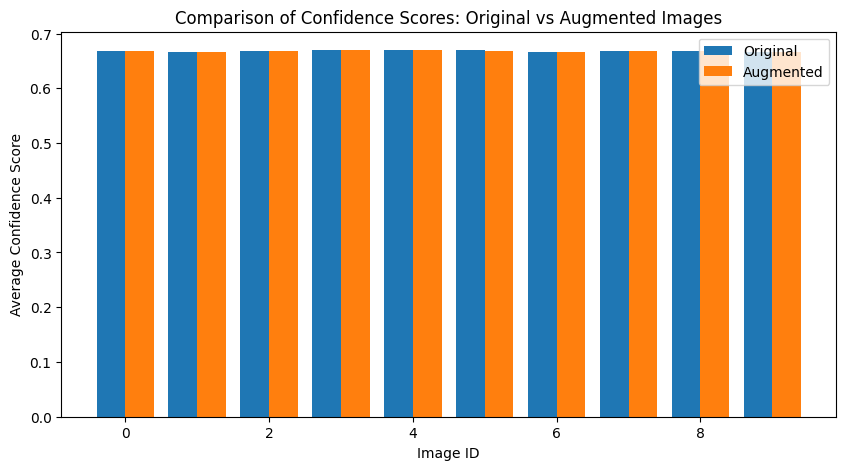

Overall mean confidence difference (Original - Augmented): 0.0002


In [24]:
# Visualize the results with a bar chart
img_ids = np.arange(len(original_avg_scores))

plt.figure(figsize=(10, 5))
plt.bar(img_ids - 0.2, original_avg_scores, width=0.4, label='Original')
plt.bar(img_ids + 0.2, augmented_avg_scores, width=0.4, label='Augmented')

plt.xlabel('Image ID')
plt.ylabel('Average Confidence Score')
plt.title('Comparison of Confidence Scores: Original vs Augmented Images')
plt.legend()
plt.show()

# Calculate the overall mean confidence difference between original and augmented images
mean_confidence_difference = np.mean(np.array(original_avg_scores) - np.array(augmented_avg_scores))
print(f"Overall mean confidence difference (Original - Augmented): {mean_confidence_difference:.4f}")